In [1]:
from bayes_tec.bayes_opt.bayes_hp_opt import BayesHPOpt
from bayes_tec.solvers.phase_only_solver import PhaseOnlySolver
from concurrent import futures
import numpy as np

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/multipledispatch-0.4.9-py3.6.egg/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/

In [ ]:

datapack = '../../scripts/data/killms_datapack_2.hdf5'
ant_sel='RS*'
time_sel=slice(1,101,1)
freq_sel=slice(0,48,1)
pol_sel=slice(0,1,1)
iterations=500
run_dir='run_dir_hp_opt'
output_solset='posterior_sol_hp_opt'



def _run(kwargs):
    solver = PhaseOnlySolver(run_dir, datapack)
    m,s = solver.solve(output_solset=output_solset, solset='sol000',
                  jitter=1e-6,tec_scale=0.005,screec_res=30,
                   remake_posterior_solsets=False, inter_op_threads=32,
                   intra_op_threads=0,ant_sel=ant_sel, time_sel=time_sel,
                   pol_sel=pol_sel, freq_sel=freq_sel,debug=False,
                   W_diag=False,return_likelihood=True,num_likelihood_samples=100,
                   plot_level=-3, **kwargs)
    return -m

def objective(**kwargs):
    return _run(kwargs)

    with futures.ThreadPoolExecutor(max_workers=2) as exe:
        jobs = exe.map(_run, [kwargs])
        res = list(jobs)
    return np.mean(res)

bo = BayesHPOpt(objective,init=None)
#     initial_learning_rate=0.1,learning_rate_steps=2,
#               learning_rate_decay=1.5,
#               minibatch_size=128, dof_ratio=30,
#              gamma_start=1e-5,gamma_add=1e-3,gamma_mul=1.1,
#              gamma_max=0.15,gamma_fallback=1e-1):
bo.add_continuous_param('initial_learning_rate',1e-3,5e-1,log=True)
bo.add_continuous_param('learning_rate_steps',2,4)
bo.add_continuous_param('learning_rate_decay',1.,3.)
bo.add_integer_param('minibatch_size',16,512)
bo.add_continuous_param('dof_ratio',15,20)
bo.add_continuous_param('gamma_start',1e-6,1e-4,log=True)
bo.add_continuous_param('gamma_add',1e-4,1e-2,log=True)
bo.add_continuous_param('gamma_mul',1.01,1.3,log=True)
bo.add_continuous_param('gamma_max',0.05,0.5)
bo.add_continuous_param('gamma_fallback',1e-2,5e-1,log=True)



    

In [ ]:
bo.run('hp_opt_results.hdf5',init_design_size=6,n_iter=50,plot=True,likelihood_uncert=1e2)

In [3]:
import pylab as plt
import numpy as np

In [4]:
d = np.load('../pre_production_runs/dof_test_res.npz')
d.keys()

['mean', 'std', 'time', 'dof']

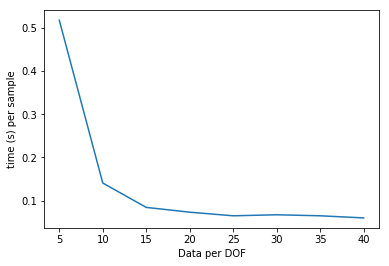

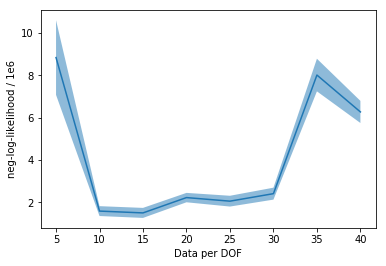

In [28]:
plt.plot(d['dof'],-d['time']/100**2)
plt.ylabel('time (s) per sample')
plt.xlabel('Data per DOF')
plt.show()

plt.plot(d['dof'],-d['mean']/1e6)
plt.fill_between(d['dof'],-d['mean']/1e6 + d['std']/1e6,-d['mean']/1e6 - d['std']/1e6,alpha=0.5)
plt.ylabel('neg-log-likelihood / 1e6')
plt.xlabel('Data per DOF')
plt.show()
